In [165]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_curve,
    precision_recall_curve, 
    roc_auc_score,
)
import pickle

# Import datasets

In [166]:
train_df = pd.read_csv('../data/train_df.csv')
val_df = pd.read_csv('../data/val_df.csv')
test_df = pd.read_csv('../data/test_df.csv')

In [167]:
train_df

,mg_acc,FSA,origin_date,property_type,purchase_price,amort_period,loan_size,interest_rate,TDS,default,Sample,cust_id,cust_age,cust_gender,cust_income,cust_cr_score,loan_years,lvr
0,733098,V2K,2012-01-12,detached,299000.0,25,239200.0,2.38,0.135672,1.0,Estimation,2277661,58,male,97500.0,900,10.742156,0.80
1,575927,V2T,2015-05-16,apartment,337000.0,25,256120.0,2.00,0.155294,0.0,Estimation,7394851,25,male,58800.0,899,7.401910,0.76
2,613989,V0N,2015-07-08,semi-detached/row/town-houses,249000.0,25,194220.0,1.67,0.117018,0.0,Estimation,1683540,54,female,70000.0,899,7.256801,0.78
3,50824,V1R,2018-03-26,detached,266000.0,25,210140.0,1.65,0.082235,0.0,Estimation,8924568,58,male,167600.0,899,4.540797,0.79
4,7399,V3S,2013-04-27,semi-detached/row/town-houses,568000.0,25,448720.0,2.11,0.294126,0.0,Estimation,936941,47,male,32900.0,898,9.452602,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,799786,V9G,2014-08-22,apartment,277000.0,30,218830.0,1.60,0.182272,0.0,Estimation,1057050,42,female,73800.0,387,8.132931,0.79
2099,18329,V8R,2018-03-07,semi-detached/row/town-houses,688000.0,25,550400.0,1.91,0.261726,0.0,Estimation,5908379,46,female,62400.0,385,4.592817,0.80
2100,942489,V1J,2018-05-05,semi-detached/row/town-houses,359000.0,25,287200.0,2.28,0.151774,0.0,Estimation,6920519,47,male,73900.0,369,4.431281,0.80
2101,793213,V2R,2018-10-29,semi-detached/row/town-houses,521000.0,25,416800.0,2.42,0.286790,0.0,Estimation,9485489,30,female,64400.0,360,3.946671,0.80


# Feature transformations

In [168]:
X_train = train_df.drop(columns=["default"])
X_test = test_df.drop(columns=["default"])
X_val = val_df.drop(columns=["default"])

y_train = train_df["default"]
y_val = val_df["default"]


In [169]:
X_train.head()

,mg_acc,FSA,origin_date,property_type,purchase_price,amort_period,loan_size,interest_rate,TDS,Sample,cust_id,cust_age,cust_gender,cust_income,cust_cr_score,loan_years,lvr
0,733098,V2K,2012-01-12,detached,299000.0,25,239200.0,2.38,0.135672,Estimation,2277661,58,male,97500.0,900,10.742156,0.80
1,575927,V2T,2015-05-16,apartment,337000.0,25,256120.0,2.00,0.155294,Estimation,7394851,25,male,58800.0,899,7.401910,0.76
2,613989,V0N,2015-07-08,semi-detached/row/town-houses,249000.0,25,194220.0,1.67,0.117018,Estimation,1683540,54,female,70000.0,899,7.256801,0.78
3,50824,V1R,2018-03-26,detached,266000.0,25,210140.0,1.65,0.082235,Estimation,8924568,58,male,167600.0,899,4.540797,0.79
4,7399,V3S,2013-04-27,semi-detached/row/town-houses,568000.0,25,448720.0,2.11,0.294126,Estimation,936941,47,male,32900.0,898,9.452602,0.79


In [170]:
train_df["property_type"].unique()

array(['detached', 'apartment', 'semi-detached/row/town-houses'],
      dtype=object)

In [171]:
train_df["FSA"].unique()

array(['V2K', 'V2T', 'V0N', 'V1R', 'V3S', 'V9R', 'V5H', 'V4B', 'V3X',
       'V9T', 'V2E', 'V3B', 'V2A', 'V1N', 'V9Y', 'V8A', 'V8B', 'V2J',
       'V4K', 'V8J', 'V4V', 'V3R', 'V1V', 'V3H', 'V0J', 'V5B', 'V1S',
       'V5P', 'V0B', 'V2B', 'V9B', 'V7G', 'V5S', 'V1E', 'V8P', 'V8T',
       'V1C', 'V8W', 'V0S', 'V1G', 'V0E', 'V7C', 'V4Z', 'V6X', 'V3A',
       'V5E', 'V3C', 'V2R', 'V4N', 'V5C', 'V3Y', 'V2L', 'V6P', 'V9C',
       'V2N', 'V2G', 'V4L', 'V0T', 'V9L', 'V3T', 'V1B', 'V0C', 'V9N',
       'V4M', 'V3J', 'V8C', 'V2P', 'V4A', 'V4R', 'V8M', 'V6Y', 'V3V',
       'V8Z', 'V9M', 'V9P', 'V1Y', 'V0R', 'V6B', 'V1M', 'V2C', 'V1T',
       'V2Z', 'V3G', 'V3Z', 'V8G', 'V1Z', 'V4C', 'V0P', 'V1X', 'V0X',
       'V5R', 'V5X', 'V9Z', 'V1J', 'V7E', 'V6V', 'V4E', 'V1W', 'V9A',
       'V2Y', 'V2S', 'V3M', 'V3L', 'V8N', 'V4T', 'V4W', 'V6K', 'V8L',
       'V2W', 'V3N', 'V6E', 'V5W', 'V6C', 'V0G', 'V9J', 'V0K', 'V6L',
       'V8V', 'V6Z', 'V9W', 'V9E', 'V9G', 'V9V', 'V9K', 'V5A', 'V3E',
       'V2X', 'V8Y',

# Build the preprocessing pipeline 

The plan:

1. One-hot encode `property_type` and `FSA`. 
2. Drop `mg_acc`,`cust_id`, `origin_date`, `Sample` as they are unique identifiers that is unlikely to be useful.
3. Drop `cust_age` and `cust_gender` because our lending algorithm is NOT allowed to depend on gender and age.
4. Treat the rest as numeric and standardize them.

In [172]:
categorical_features = ["property_type", "FSA"]
drop_features = ["mg_acc","cust_id","origin_date","cust_age","cust_gender", "Sample"]
numeric_features = list(
    set(train_df.columns)
    - set(["default"])
    - set(categorical_features)
    - set(drop_features)
)

In [173]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(),StandardScaler()),
        numeric_features
    ),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    ("drop", drop_features),
)

In [174]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['loan_size', 'cust_cr_score', 'loan_years',
                                  'cust_income', 'interest_rate', 'lvr',
                                  'amort_period', 'purchase_price', 'TDS']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['property_type', 'FSA']),
                                ('drop', 'drop',
                                 ['mg_acc', 'cust_id', 'origin_date',
                                  'cust_age', 'cust_gender', 'Sample'])])

In [175]:
preprocessor.named_transformers_

{'pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 'onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'drop': 'drop'}

In [176]:
new_columns = (
    numeric_features
    + list(
        preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
            categorical_features
        )
    )
)

In [177]:
pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)

,loan_size,cust_cr_score,loan_years,cust_income,interest_rate,lvr,amort_period,purchase_price,TDS,property_type_apartment,...,FSA_V9N,FSA_V9P,FSA_V9R,FSA_V9S,FSA_V9T,FSA_V9V,FSA_V9W,FSA_V9X,FSA_V9Y,FSA_V9Z
0,-0.888479,1.709617,1.849176,0.496924,0.666542,0.646032,-0.292795,-0.900511,-1.287748,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.813624,1.699841,0.314573,-0.600262,-0.163173,-1.440919,-0.292795,-0.768973,-1.081751,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.087474,1.699841,0.247905,-0.282730,-0.883715,-0.397444,-0.292795,-1.073587,-1.483580,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.017043,1.699841,-0.999904,2.484335,-0.927384,0.124294,-0.292795,-1.014741,-1.848740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.038454,1.690065,1.256719,-1.334555,0.077008,0.124294,-0.292795,0.030640,0.375725,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,-0.978598,-3.305477,0.650424,-0.174996,-1.036557,0.124294,1.808733,-0.976665,-0.798532,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2099,0.488295,-3.325029,-0.976004,-0.498198,-0.359684,0.646032,-0.292795,0.446024,0.035590,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2100,-0.676123,-3.481446,-1.050218,-0.172161,0.448196,0.646032,-0.292795,-0.692819,-1.118709,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2101,-0.102762,-3.569430,-1.272862,-0.441496,0.753881,0.646032,-0.292795,-0.132052,0.298712,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Hyperparameter Tuning

## 1. SVM Training:

In [178]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
import random 
random.seed(123)

svc_param_grid = {
    "gamma": np.logspace(-3, 2, 6), 
    "C": np.linspace(2, 4, 6),
    "kernel": ["linear",'rbf']
}

In [179]:
data = {'ml':[], "model":[], "val_roc_auc_score":[], "train_roc_auc_score":[]}
for g in random.choices(ParameterGrid(svc_param_grid), k=20):
    pipe_svm = make_pipeline(preprocessor, SVC(**g,class_weight='balanced',random_state=123,probability=True))
    pipe_svm.fit(X_train,y_train)
    data["ml"].append('SVM')
    data["model"].append(g)
    data['val_roc_auc_score'].append(roc_auc_score(y_val, pipe_svm.predict(X_val)))
    data['train_roc_auc_score'].append(roc_auc_score(y_train, pipe_svm.predict(X_train)))

In [180]:
svm = pd.DataFrame(data).sort_values(by="val_roc_auc_score", ascending=False)
svm

,ml,model,val_roc_auc_score,train_roc_auc_score
8,SVM,"{'kernel': 'rbf', 'gamma': 0.001, 'C': 4.0}",0.650844,0.631662
0,SVM,"{'kernel': 'rbf', 'gamma': 0.01, 'C': 2.0}",0.648201,0.658002
18,SVM,"{'kernel': 'linear', 'gamma': 100.0, 'C': 2.4}",0.637804,0.691588
15,SVM,"{'kernel': 'linear', 'gamma': 1.0, 'C': 2.0}",0.637804,0.692037
13,SVM,"{'kernel': 'linear', 'gamma': 0.001, 'C': 2.0}",0.637804,0.692037
11,SVM,"{'kernel': 'linear', 'gamma': 0.001, 'C': 2.8}",0.637804,0.691588
1,SVM,"{'kernel': 'linear', 'gamma': 1.0, 'C': 2.0}",0.637804,0.692037
10,SVM,"{'kernel': 'linear', 'gamma': 0.001, 'C': 2.8}",0.637804,0.691588
5,SVM,"{'kernel': 'linear', 'gamma': 0.01, 'C': 2.0}",0.637804,0.692037
19,SVM,"{'kernel': 'linear', 'gamma': 10.0, 'C': 2.8}",0.637804,0.691588


In [181]:
svm_best_params = svm.iloc[0,1]
svm_best = make_pipeline(preprocessor,  SVC(**svm_best_params,class_weight='balanced',random_state=123,probability=True))
svm_best.fit(X_train, y_train)
pickle.dump(svm_best, open('../models/svm.pkl', 'wb'))

## 2. Logistic regression Training:

In [182]:
lr_param_grid = {
    "penalty": ['l1','l2'], 
    "C": np.logspace(-3, 2, 6)
}

In [183]:
data = {'ml':[], "model":[], "val_roc_auc_score":[], "train_roc_auc_score":[]}
for g in random.choices(ParameterGrid(lr_param_grid), k=20):
    pipe_lr = make_pipeline(preprocessor, LogisticRegression(**g, class_weight='balanced',max_iter = 4000, solver='saga',random_state=123))
    pipe_lr.fit(X_train,y_train)
    data["ml"].append('LR')
    data["model"].append(g)
    data['val_roc_auc_score'].append(roc_auc_score(y_val, pipe_lr.predict(X_val)))
    data['train_roc_auc_score'].append(roc_auc_score(y_train, pipe_lr.predict(X_train)))

In [184]:
lr = pd.DataFrame(data).sort_values(by="val_roc_auc_score", ascending=False)
lr

,ml,model,val_roc_auc_score,train_roc_auc_score
7,LR,"{'penalty': 'l2', 'C': 0.01}",0.654573,0.631256
16,LR,"{'penalty': 'l2', 'C': 0.01}",0.654573,0.631256
10,LR,"{'penalty': 'l1', 'C': 0.1}",0.652679,0.626825
17,LR,"{'penalty': 'l1', 'C': 0.1}",0.652679,0.626825
8,LR,"{'penalty': 'l1', 'C': 100.0}",0.645952,0.691018
0,LR,"{'penalty': 'l1', 'C': 100.0}",0.645952,0.691018
5,LR,"{'penalty': 'l1', 'C': 100.0}",0.645952,0.691018
6,LR,"{'penalty': 'l1', 'C': 1.0}",0.645893,0.669787
9,LR,"{'penalty': 'l2', 'C': 10.0}",0.645893,0.686651
11,LR,"{'penalty': 'l2', 'C': 10.0}",0.645893,0.686651


In [185]:
lr_best_params = lr.iloc[0,1]
lr_best = make_pipeline(preprocessor, LogisticRegression(**lr_best_params, class_weight='balanced',max_iter = 4000, solver='saga',random_state=123))
lr_best.fit(X_train, y_train)
pickle.dump(lr_best, open('../models/lr.pkl', 'wb'))

In [186]:
coef_df.reset_index()

,index,coefficient,magnitude
0,TDS,0.449501,0.449501
1,property_type_apartment,0.219853,0.219853
2,lvr,0.149044,0.149044
3,property_type_detached,-0.133372,0.133372
4,loan_years,-0.089050,0.089050
...,...,...,...
186,FSA_V6Z,0.000742,0.000742
187,FSA_V5M,-0.000690,0.000690
188,FSA_V6K,0.000656,0.000656
189,FSA_V4A,0.000600,0.000600


### 3.1 Feature Importance

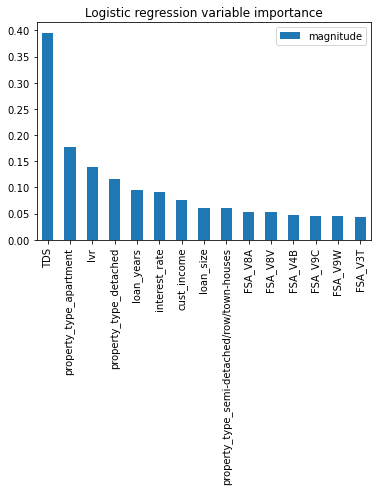

In [187]:
coefs = lr_best.named_steps["logisticregression"].coef_
data = {
    "coefficient": lr_best.named_steps["logisticregression"].coef_.tolist()[0],
    "magnitude": np.absolute(lr_best.named_steps["logisticregression"].coef_).tolist()[0],
}
coef_df = pd.DataFrame(data, index=new_columns).sort_values(
    "magnitude", ascending=False
)

coef_df[:15].plot.bar(y="magnitude", title="Logistic regression variable importance");

## 3. Random Forest Training:

In [188]:
rf_param_grid = {'bootstrap': [True, False],
               'max_depth': [2,4],
               'max_features': ['sqrt', 'log2'],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]}

In [189]:
data = {'ml':[], "model":[], "val_roc_auc_score":[], "train_roc_auc_score":[]}
for g in random.choices(ParameterGrid(rf_param_grid), k=20):
    pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(**g,class_weight='balanced',random_state=123))
    pipe_rf.fit(X_train,y_train)
    data["ml"].append('RF')
    data["model"].append(g)
    data['val_roc_auc_score'].append(roc_auc_score(y_val, pipe_rf.predict(X_val)))
    data['train_roc_auc_score'].append(roc_auc_score(y_train, pipe_rf.predict(X_train)))

In [190]:
rf = pd.DataFrame(data).sort_values(by="val_roc_auc_score", ascending=False)
rf

,ml,model,val_roc_auc_score,train_roc_auc_score
10,RF,"{'n_estimators': 80, 'min_samples_split': 2, '...",0.637508,0.664711
11,RF,"{'n_estimators': 180, 'min_samples_split': 5, ...",0.637094,0.664042
19,RF,"{'n_estimators': 30, 'min_samples_split': 5, '...",0.636995,0.641958
3,RF,"{'n_estimators': 150, 'min_samples_split': 2, ...",0.635831,0.671559
17,RF,"{'n_estimators': 190, 'min_samples_split': 2, ...",0.635456,0.673149
8,RF,"{'n_estimators': 50, 'min_samples_split': 2, '...",0.633720,0.659054
6,RF,"{'n_estimators': 200, 'min_samples_split': 10,...",0.633049,0.659220
15,RF,"{'n_estimators': 160, 'min_samples_split': 2, ...",0.629478,0.668476
16,RF,"{'n_estimators': 110, 'min_samples_split': 2, ...",0.628926,0.640182
7,RF,"{'n_estimators': 110, 'min_samples_split': 5, ...",0.628295,0.640937


In [191]:
rf_best_params = rf.iloc[0,1]
rf_best = make_pipeline(preprocessor, RandomForestClassifier(**rf_best_params,class_weight='balanced',random_state=123))
rf_best.fit(X_train, y_train)
pickle.dump(rf_best, open('../models/rf.pkl', 'wb'))

### 3.1 Feature Importance

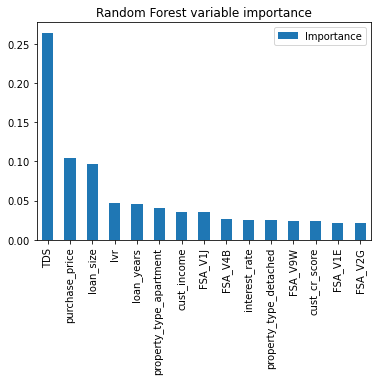

In [192]:
data = {
    "Importance": rf_best.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(
    data=data,
    index=new_columns,
).sort_values(by="Importance", ascending=False)

imps[:15].plot.bar(y="Importance", title="Random Forest variable importance");

## 4. XGboost Training:

In [193]:
xgb_param_grid = {
 'eta': [0.05,0.1,0.3],
 "n_estimators": [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)],
 "learning_rate" : [0.01,0.1,0.2,0.5,1],
 "max_depth" : [2, 3, 5, 8, 12],
 "gamma": np.logspace(-2, 2, 6),
 "booster": ['gbtree','gblinear'],
}

In [194]:
data = {'ml':[], "model":[], "val_roc_auc_score":[], "train_roc_auc_score":[]}

for g in random.choices(ParameterGrid(xgb_param_grid), k=20):
    pipe_xgb = make_pipeline(preprocessor, XGBClassifier(**g,class_weight='balanced',use_label_encoder =False, verbosity=0, random_state=123))
    pipe_xgb.fit(X_train,y_train)
    data["ml"].append('XGB')
    data["model"].append(g)
    data['val_roc_auc_score'].append(roc_auc_score(y_val, pipe_xgb.predict(X_val)))
    data['train_roc_auc_score'].append(roc_auc_score(y_train, pipe_xgb.predict(X_train)))

In [195]:
xgb = pd.DataFrame(data).sort_values(by="val_roc_auc_score", ascending=False)
xgb

,ml,model,val_roc_auc_score,train_roc_auc_score
0,XGB,"{'n_estimators': 40, 'max_depth': 2, 'learning...",0.538747,0.646062
4,XGB,"{'n_estimators': 150, 'max_depth': 3, 'learnin...",0.530086,0.846663
19,XGB,"{'n_estimators': 150, 'max_depth': 12, 'learni...",0.528015,1.000000
1,XGB,"{'n_estimators': 70, 'max_depth': 12, 'learnin...",0.522767,0.719439
3,XGB,"{'n_estimators': 110, 'max_depth': 3, 'learnin...",0.518742,0.593988
9,XGB,"{'n_estimators': 190, 'max_depth': 12, 'learni...",0.518525,0.577487
16,XGB,"{'n_estimators': 160, 'max_depth': 5, 'learnin...",0.517894,0.576732
12,XGB,"{'n_estimators': 200, 'max_depth': 3, 'learnin...",0.517894,0.576732
2,XGB,"{'n_estimators': 100, 'max_depth': 2, 'learnin...",0.517894,0.576732
11,XGB,"{'n_estimators': 140, 'max_depth': 5, 'learnin...",0.517894,0.576732


In [200]:
xgb_best_params = xgb.iloc[1,1]
xgb_best = make_pipeline(preprocessor, XGBClassifier(**xgb_best_params,class_weight='balanced',random_state=123))
xgb_best.fit(X_train, y_train)
pickle.dump(xgb_best, open('../models/xgb.pkl', 'wb'))

/opt/miniconda3/envs/573/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [201]:
nn_param_grid = {
    'alpha': [0.05, 0.01, 0.005, 0.001],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation':['logistic', 'tanh', 'relu']}

In [202]:
data

{'ml': ['XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB',
  'XGB'],
 'model': [{'n_estimators': 40,
   'max_depth': 2,
   'learning_rate': 1,
   'gamma': 0.01,
   'eta': 0.1,
   'booster': 'gbtree'},
  {'n_estimators': 70,
   'max_depth': 12,
   'learning_rate': 0.01,
   'gamma': 2.5118864315095824,
   'eta': 0.05,
   'booster': 'gbtree'},
  {'n_estimators': 100,
   'max_depth': 2,
   'learning_rate': 0.5,
   'gamma': 15.848931924611142,
   'eta': 0.05,
   'booster': 'gblinear'},
  {'n_estimators': 110,
   'max_depth': 3,
   'learning_rate': 0.2,
   'gamma': 0.01,
   'eta': 0.05,
   'booster': 'gbtree'},
  {'n_estimators': 150,
   'max_depth': 3,
   'learning_rate': 0.5,
   'gamma': 0.01,
   'eta': 0.3,
   'booster': 'gbtree'},
  {'n_estimators': 50,
   'max_depth': 3,
   'learning_rate': 0.1,
   'gamma': 0.3981071705534973,
   'eta': 0.1,
   'booster': 'gbtree'},
  {'

In [203]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

NameError: name 'X' is not defined

# Ensemble method (voting ensemble)

In [204]:
from sklearn.ensemble import VotingClassifier
models = {
    "logistic regression": lr_best,
    "random forest": rf_best,
    "svm": svm_best,
    'xgb_boost': xgb_best
}

In [205]:
averaging_model = VotingClassifier(list(models.items()), voting='soft')
averaging_model.fit(X_train, y_train);
data = {'ml':[], "model":[], "val_roc_auc_score":[], "train_roc_auc_score":[]}
data["ml"].append('voting ensemble')
data["model"].append(['svm','lr','rf','xgb_boost'])
data['val_roc_auc_score'].append(roc_auc_score(y_val, averaging_model.predict(X_val)))
data['train_roc_auc_score'].append(roc_auc_score(y_train, averaging_model.predict(X_train)))

/opt/miniconda3/envs/573/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [206]:
pd.DataFrame(data).sort_values(by="val_roc_auc_score", ascending=False)

,ml,model,val_roc_auc_score,train_roc_auc_score
0,voting ensemble,"[svm, lr, rf, xgb_boost]",0.552024,0.706942


In [207]:
pickle.dump(averaging_model, open('../models/ensemble.pkl', 'wb'))